<a href="https://colab.research.google.com/github/soneyahossain/deep_learning_project/blob/master/deep_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!unzip DATA.zip


In [0]:
import torch.utils.data
import json, os
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torchvision.transforms as transforms
import pandas as pd


class UVaBuildinglabel(torch.utils.data.Dataset):
    def __init__(self, image_path, annotation_filepath, transform = None):
        super(UVaBuildinglabel, self).__init__()
        
        print('Loading data...')
        data = pd.read_csv(annotation_filepath)              #json.load(open(annotation_filepath, 'rb'))
        
        self.transform = transforms.Compose(
        [transforms.Resize(320),  # 1. Resize smallest side to 256.
        transforms.RandomCrop(320), # 2. Crop random square of 224x224 pixels.
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])
        
        self.image_path = image_path    # storing image path. 
        
        
        # get the image pixel values and labels
        image_ids = data.iloc[:, 0 ]
        label_ids = data.iloc[:, 1]
        label_names = data.iloc[:, 2]

        self.image_ids = data.iloc[:, 0 ] #[img_name for (img_id, img_name) in paired_id_names]
        self.image_labels = data.iloc[:, 1]   #[img_id for (img_id, img_name) in paired_id_names]
        self.image_classes= data.iloc[:, 2]


        print(image_ids[0])
        print(label_ids[0])
        print(label_names)

        
    def __getitem__(self, index):
        image_name = self.image_ids[index]
        img_ = Image.open(open(os.path.join(self.image_path, image_name), 'rb'))
        img_ = img_.convert("RGB")
        if self.transform:
            img_ = self.transform(img_)
        label_ = self.image_labels[index]
        class_name= self.image_classes[index]
        return img_, label_, image_name,class_name 
    
    def __len__(self):
        return len(self.image_ids)
       
      
# You can unnormalize the transformation of torch's transforms.normalize 
# with this custom transformation.
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

trainset = UVaBuildinglabel('DATA', 'trainSet.csv')
valset = UVaBuildinglabel('DATA', 'valSet.csv')

In [0]:
import matplotlib.pyplot as plt

x = range(0, 413)

for i in x:
     my_image, my_label,_,class_name  = trainset.__getitem__(i)

print(my_image.shape)
print(my_label)

# Show the image and its label.
plt.figure()
label = class_name
plt.title("This picture has: "+label)
# Undo normalization of the pixel values.

# Re-arrange dimensions so it is height x width x channels.
plt.imshow(my_image.transpose(0,2).transpose(0,1));
#plt.grid(False); plt.axis('off');

This dataset has 414 training images
16
320
Image 320 is a The Rotunda
Image size is 3x320x320


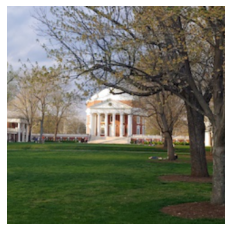

In [37]:
import torchvision.transforms.functional as F

image_index = 320  # Feel free to change this.

classes = ['Rice Hall', 'Wilsdorf Hall', 'Thornton Hall', 'Physics Building', 'Olsson Hall', 
           'Mechanical Building', 'Law School Building', 'John Paul Jones Arena', 'Chemical Engineering Building', 
           'Aquatic & Fitness Center', 'Scott Stadium', 'Alderman Library', 'Newcomb Hall', 
           'Old Cabell Hall', 'Rotunda', 'Monroe Hall', 'Slaughter Recreation', 'North Grounds Gym',
           'Alumni Hall', 'Memorial Gym']


# 1. Datasets need to implement the __len__ method for this to work.
print('This dataset has {0} training images'.format(len(trainset)))

# 2. Datasets need to implement the  __getitem__ method for this to work.
img, label,_,class_name = trainset[image_index]  # Returns image and label.

print(label)
print(image_index)
print('Image {0} is a {1}'.format(image_index, class_name))
print('Image size is {0}x{1}x{2}'.format(img.shape[0], img.shape[1], img.shape[2]))
# All images have 1 channel x 28 rows x 28 columns.

plt.figure()
plt.imshow(img.transpose(0,2).transpose(0,1));
plt.grid(False); plt.axis('off')
plt.show()

In [0]:
# Your code.

# Define a learning rate. 
learningRate = 1e-4

# Define number of epochs.
N = 8

# Initialize bias and weight with random values again.
weight = torch.empty(20, 3 * 320 * 320).normal_(0, 0.01)
bias = torch.zeros(20, 1)

# log accuracies and losses.
train_accuracies = []; 
val_accuracies = []
train_losses = []; 
val_losses = []

# Training loop. Please make sure you understand every single line of code below.
# Go back to some of the previous steps in this lab if necessary.
for epoch in range(0, N):
    correct = 0.0
    cum_loss = 0.0
    
    # Make a pass over the training data.
    for (i, (img, label,_,_)) in enumerate(trainset):
        x = img
        x = x.view(3 * 320 * 320, 1)
        
        # Forward pass. (Prediction stage)
        predictions = softmax(linear(x, weight, bias))
        cum_loss += loss(label, predictions).item()
        max_score, max_label = predictions.max(0)
        if max_label[0] == label: correct += 1
        
        #Backward pass. (Gradient computation stage)
        gradOutput = loss_softmax_backward(label, predictions)
        gradWeight, gradBias = linear_backward(x, weight, bias, gradOutput)
        
        # Parameter updates.
        weight.add_(-learningRate, gradWeight)
        bias.add_(-learningRate, gradBias)
        
        # Logging the current results on training.
        if (i + 1) % 1000 == 0:
            print('Train-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
                  (epoch, i + 1, cum_loss / (i + 1), correct / (i + 1)))
    
    train_accuracies.append(correct / len(trainset))
    train_losses.append(cum_loss / len(trainset))
    
    
    # Make a pass over the validation data.
    correct = 0.0
    cum_loss = 0.0
    for (i, (img, label,_,_)) in enumerate(valset):
        x = F.to_tensor(img)
        x = x.view(3 * 320 * 320, 1)
        
        # Forward pass. (Prediction stage)
        predictions = softmax(linear(x, weight, bias))
        cum_loss += loss(label, predictions).item()
        max_score, max_label = predictions.max(0)
        if max_label[0] == label: correct += 1
          
          
    val_accuracies.append(correct / len(valset))
    val_losses.append(cum_loss / len(valset))
            
    # Logging the current results on validation.
    print('Validation-epoch %d. Avg-Loss: %.4f, Accuracy: %.4f' % 
          (epoch, cum_loss / len(valset), correct / len(valset)))
#--------------------------------------------------------------------------

plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(val_losses, 'bo-', label = 'val-loss')
plt.plot(train_losses, 'ro-', label = 'train-loss')
plt.grid('on')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation', 'training'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, 'bo-', label = 'val-acc')
plt.plot(train_accuracies, 'ro-', label = 'train-acc')
plt.ylabel('accuracy')
plt.grid('on')
plt.xlabel('epoch')
plt.legend(['validation', 'training'], loc='lower right')
plt.show()